# Computação Cognitiva 3
## Trabalho de avaliação da discplina
## Agosto 2021
## Pós Graduação em Inteligência Artificial - IANB - 2020

### Explicação

O trabalho consiste de testar diferentes classificadores em uma base de sentimento de tweets já anotada (Sentiment140). Especificamente, pedem-se dois classificadores clássicos e um classificador utilizando deep learning.

In [29]:
import re
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from html import unescape

from math import floor

import gensim
from gensim.models import Word2Vec

from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM

from string import punctuation, whitespace


ImportError: cannot import name 'CategoricalCrossEntropy' from 'tensorflow.keras.losses' (/home/blue/iesb_venv/lib/python3.8/site-packages/keras/api/_v2/keras/losses/__init__.py)

### Análise Exploratória

In [2]:
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin1')
column_names = ['sentimento', 'tweet_id', 'datetime', 'query', 'text']

tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


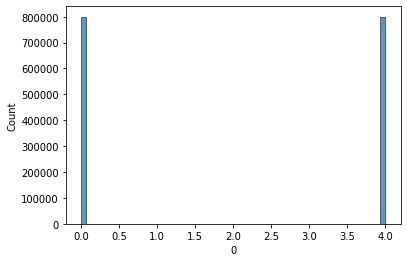

In [3]:
# Tweets únicos
len(tweets[1]) - len(tweets[1].unique())
# Percebe-se que há 1685 tweets com mesmo identificador
# Para não gerar ambiguidades na classificação, os ids duplicados foram removidos da base
tweets = tweets[~tweets.duplicated(subset=[1])].copy()
# Remove as duplicatas

# Sentimentos anotados
sns.histplot(tweets[0])
plt.show()

Percebe-se que os dados estão balanceados em aproximadamente 800.000 amostras de tweets negativos (0) e positivos (4)

In [4]:
# Tipo de query
tweets[3].unique()


array(['NO_QUERY'], dtype=object)

Todos os tweets na base advem de uma coleta sem query específica. Isso é menos um elemento de potencial viés para base

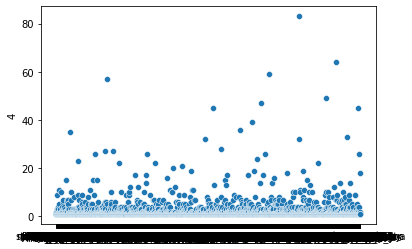

In [5]:
# Usuários
plot_data = tweets[4].value_counts()
plot_data = plot_data.sample(2500)
query = sns.scatterplot(data=plot_data, x=plot_data.index, y=plot_data)
query.set(xlabel=None)
plt.show()

Ainda que não tenha sido possível plotar todos os usuários, não parece haver uma concentração anormal de tweets
em determinados usuários, sabendo que não há queries específicas e o conhecendo o funcionamento da API, é possível
assumir qua não há viés relacionado à coleta concentrada em determinados usuarios

/home/blue/iesb_venv/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


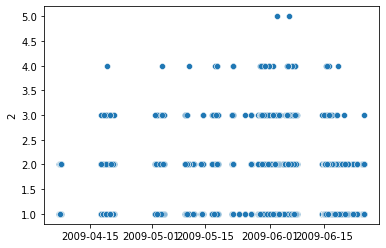

In [6]:
# Tempo
plot_data = tweets[2].sample(100000)
plot_data = pd.to_datetime(plot_data).value_counts()
sns.scatterplot(data=plot_data, x=plot_data.index, y=plot_data)
plt.show()

Os tweets referem-se a publicações entre abril e junho de 2009. Em função do grande número de pontos a plotar, foram amostrados 100.000

/home/blue/iesb_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


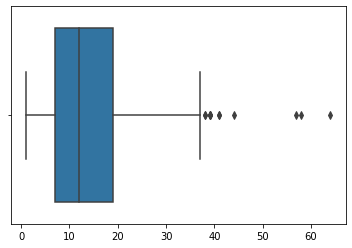

In [7]:
# Tamanho dos tweets
# Importante para a tokenização
split_tweets = [tweet.split() for tweet in tweets[5].values]
word_count = [len(tweet) for tweet in split_tweets]
word_count

plot = sns.boxplot(word_count)
plt.show()

Apenas outliers entre os tweets têm mais de 40 palavras. Essa informação é importante para decidir o tamanho máximo de modelos de deep learning sequenciais que precisem de crop ou padding no tamanho textual.

In [8]:
del tweets

### Modelos de classificação

Para o pré-processamento, adotaram-se os seguintes passos:
* Remoção de urls
    * por se entender que se tratam de ruídos no que tange a classificação de sentimento
* Remoção de menções
    * por se entender que se tratam de ruídos no que tange a classificação de sentimento
* Remoção de hashtags
    * por se entender que se tratam de ruídos no que tange a classificação de sentimento
* Conversão de caracteres html escapados para caracteres legíveis
    * Alguns tweets mantinham a formatação de escape em html
* Remoção de stopwords
    * Para diminuição da dimensionalidade e remoção de ruído
* Conversão a caixa baixa
    * Para não se gerarem tokens da mesma palavra diferentes apenas pela capitalização
* Lematização dos termos
    * Para diminuição da dimensionalidade e remocação de ruído

Caracteres de pontuação não foram removidos uma vez que alguns tweets contavam com emoticons que podem ser usados para auxiliar a classificação.

Para vetorizar o espaço, adotou-se inicialmente a vetorização por TF-IDF

Como modelos clássicos, foram adotados classificadores:
* `DecisionTree`
* `SVM`

Como modelo de deep learning, foi adotada uma rede recorrente `LSTM` com uma única entrada, corresponde ao vetor TF-IDF do documento. Essa abordagem, entretanto, não faz uso da capacidade da camada LSTM de ponderar a sequência de termos, uma vez que a vetorização TF-IDF em um vetor unidmensional descarta essa informação

#### Variáveis do ambiente

In [9]:
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin1')
tweets = tweets[~tweets.duplicated(subset=[1], keep=False)].copy()

# Separa as colunas de interesse
y_orig = tweets[0]
X_orig = tweets[5]

del tweets

# Padrões regex para pré-Processamento
padroes = {
    'mencao': re.compile(r'(@[A-Za-z0-9_]{1,15}:?)'),
    'hashtag': re.compile(r'(#[A-Za-z0-9_])'),
    'urls': re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'),
    'punct': re.compile(f'\w+([{punctuation}]+)[{whitespace}]'),
}

# Remove do texto pedações de strings que se encaixem em um padrão regex fornecido
def limpar_padrao(texto: str, padrao: re.Pattern):
    return padrao.sub('', texto)

# Sequência de pré-processamento padrão para os modelos clássicos
def sequencia_pre_processamento(input_data):
    out = [limpar_padrao(x, padroes['mencao']) for x in input_data]
    out = [limpar_padrao(x, padroes['hashtag']) for x in out]
    out = [limpar_padrao(x, padroes['urls']) for x in out]
    # Apesar de emojis terem sido removidos, ainda há alguns emoticos, talvez n valha a pena retirar pontuação
    # out = [limpar_padrao(x, padroes['punct']) for x in out]
    out = [x.lower() for x in out]
    out = [x.strip() for x in out]

    # reparseia entidades html: e.g: &gt >;
    out = [unescape(x) for x in out]

    return out


def lematizar(input_data):

    def get_wordnet_pos(treebank_tag):
        # https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.ADV

    wnl = WordNetLemmatizer()

    out = [word_tokenize(tweet) for tweet in input_data]
    out = [pos_tag(tweet) for tweet in out]
    out = [[wnl.lemmatize(word[0], pos=get_wordnet_pos(word[1])) for word in tweet] for tweet in out]
    out = [' '.join(tweet) for tweet in out]

    return out

def vetorizar(input_data):
    vetorizador = TfidfVectorizer(stop_words='english', max_features=None)
    vetorizador.fit(input_data)
    out = vetorizador.transform(input_data)

    return vetorizador, out

# Rotina de preparação dos modelos clássicos
def rotina_classica(m):
    """Rotina de configuração de uma instância que herda do método geral"""
    # Remove caracteres, ruídos, transforma o escape html e converte tudo a caixa baixa
    m.preprocess()
    # Lematiza os termos
    m.lematizar()
    # Gera o transformador TF-IDF com stopwords em inglês com os dados de treino
    m.gen_tfidf()
    # Aplica a transformação aos dados de treino
    m.transform_train()
    # Aplica a transformação aos dados de teste
    m.transform_test()
    # Treina o modelo
    m.treinar()
    return m

# Rotina de comparação de resultados dos modelos clássicos
def gerar_indicadores(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, pos_label=4)
    rec = recall_score(y_true, y_pred, pos_label=4)
    pre = precision_score(y_true, y_pred, pos_label=4)
    acc = accuracy_score(y_true, y_pred)

    return acc, pre, rec, f1

# Rotina para printar resultados
def printar_indicadores(tupla):
    """Recebe tupla dos 4 indicadores"""
    print(f'Acurácia:\t{tupla[0]}')
    print(f'Precisão:\t{tupla[1]}')
    print(f'Recall:\t\t{tupla[2]}')
    print(f'Score F1:\t{tupla[3]}')

#### Classe Base

In [10]:
class MetodoGeral:
    def __init__(self, x_set, y_set, seed=123):
        self.X_orig = x_set
        self.y_orig = y_set
        self.seed = seed if seed is not None else None
        self.split_set = None

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_orig, self.y_orig, train_size=20000, test_size=2000, random_state=self.seed)

        self.vetorizador = TfidfVectorizer(stop_words='english', max_features=None)
        
        self.clf = None

    def preprocess(self):
        self.X_train = sequencia_pre_processamento(self.X_train)
        self.X_test = sequencia_pre_processamento(self.X_test)

    def lematizar(self):
        self.X_train = lematizar(self.X_train)
        self.X_test = lematizar(self.X_test)

    def gen_tfidf(self):
        self.vetorizador.fit(self.X_train)
        self.vetorizador.transform(self.X_train)

    def transform_train(self):
        self.X_train = self.vetorizador.transform(self.X_train)

    def transform_test(self):
        self.X_test = self.vetorizador.transform(self.X_test)

    def treinar(self):
        self.clf.fit(self.X_train, self.y_train)

    def prever(self):
        return self.clf.predict(self.X_test)

#### Classificador Decision Tree

##### Definição

In [11]:
class Metodo1DecisionTree(MetodoGeral):
    def __init__(self, x_set, y_set, seed=123):
        super().__init__(x_set, y_set, seed=seed)

        self.clf = DecisionTreeClassifier(random_state=self.seed)

##### Instaciamento, treino, teste e métricas

In [12]:
m_dt = Metodo1DecisionTree(X_orig, y_orig)
m_dt = rotina_classica(m_dt)
y_pred = m_dt.prever()
indicadores_dt = gerar_indicadores(m_dt.y_test, y_pred)

##### Análise das métricas

In [13]:
printar_indicadores(indicadores_dt)

Acurácia:	0.6715
Precisão:	0.6686507936507936
Recall:		0.6760280842527583
Score F1:	0.6723192019950125


#### Classificador SVM

##### Definição

In [14]:
class Metodo2Svm(MetodoGeral):
    def __init__(self, x_set, y_set, seed=123):
        super().__init__(x_set, y_set, seed=seed)

        self.clf = SVC(random_state=self.seed)

##### Instanciamento, treino, teste e métricas

In [15]:
m_svc = Metodo2Svm(X_orig, y_orig)
m_svc = rotina_classica(m_svc)
y_pred = m_svc.prever()
indicadores_svm = gerar_indicadores(m_svc.y_test, y_pred)

##### Análise das métricas

In [16]:
printar_indicadores(indicadores_svm)

Acurácia:	0.722
Precisão:	0.7138700290979632
Recall:		0.7382146439317954
Score F1:	0.7258382642998027


#### Classificador LSTM - TF-IDF

##### Definição

In [41]:
class Metodo4NeuralNetworkKerasMLP(MetodoGeral):
    
    def __init__(self, x_set, y_set, seed=123):
        super().__init__(x_set, y_set, seed=seed)

        self.y_train = self.y_train/4
        self.y_test = self.y_test /4

        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(
            self.X_train, self.y_train, test_size=.2, random_state=self.seed)

        es = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=True,
                           mode='auto',
                           restore_best_weights=True)
        mc = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_accuracy',
                             verbose=True,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')
        self.callbacks = [es, mc]
        self.BATCH_SIZE = 128
        self.EPOCHS = 100

        self.hist = None

    # def set_up_model(self): #### Método pode ser comentado no notebook, já que esse MLP não será usado

    # def data_generator(self, x_set=None, y_set=None): # Método pode ser comentado no notebook, já que LSTM pede entrada diferente da MLP

    def predict_gen(self):
        iter_x = iter(copy.deepcopy(self.X_test))
        while True:
            # obs: esse método precisa ser chamado após X_train receber a transformação de espaço para tdidf
            x = np.zeros((self.BATCH_SIZE, self.X_test.shape[1]))
            for i in range(self.BATCH_SIZE):
                try:
                    x[i] = next(iter_x).toarray()
                except StopIteration:
                    return
                yield x

    def treinar(self):
        g = self.data_generator()
        valid = self.data_generator(self.X_valid, self.y_valid)
        # Uso de fit_generator: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
        self.hist = self.clf.fit_generator(g,
                                           steps_per_epoch=floor(self.X_train.shape[0]/self.BATCH_SIZE),
                                           epochs=self.EPOCHS,
                                           verbose=1,
                                           callbacks=self.callbacks,
                                           validation_data=valid,
                                           validation_steps=floor(self.X_train.shape[0]/self.BATCH_SIZE),
                                           use_multiprocessing=True)

    def test(self):
        G = self.predict_gen()
        pred = self.clf.predict(G,
                                steps=floor(self.X_test.shape[0]/self.BATCH_SIZE))

        return pred
    
    
class Metodo7BagOfWordsLSTM(Metodo4NeuralNetworkKerasMLP):

    def set_up_model(self):
        
        self.preprocess()
        self.lematizar()
        self.gen_tfidf()
        self.transform_train()
        self.transform_test()

        self.X_valid = sequencia_pre_processamento(self.X_valid)
        self.X_valid = lematizar(self.X_valid)
        self.X_valid = self.vetorizador.transform(self.X_valid)

        model = Sequential()
        # model.add(Input(shape=(1, self.X_train.shape[1]),
        #                name='entrada'))  # argumento sparse=True não permitiu processar matriz esparsa no treino
        model.add(LSTM(units=256, name='1a_cr', input_shape=(1, self.X_train.shape[1])))
        model.add(Dropout(.25))
        model.add(Dense(units=256, activation='relu', name='1a_cd'))
        model.add(Dropout(.25))
        model.add(Dense(units=128, activation='relu', name='2a_cd'))
        model.add(Dense(units=1, activation='sigmoid', name='saida'))

        model.summary()

        model.compile(loss=BinaryCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])

        self.clf = model

    def data_generator(self, x_set=None, y_set=None):
        # Erro ao passar matriz esparsa 'SparseTensor' object is not subscriptable
        # https://stackoverflow.com/questions/53779968/why-keras-fit-generator-load-before-actually-training
        x_set = self.X_train if x_set is None else x_set
        y_set = self.y_train if y_set is None else y_set

        iter_x = iter(copy.deepcopy(x_set))
        iter_y = iter(copy.deepcopy(y_set))
        while True:
            #obs: esse método precisa ser chamado após X_train receber a transformação de espaço para tdidf
            x = np.zeros((self.BATCH_SIZE, 1, x_set.shape[1]))
            y = np.zeros(self.BATCH_SIZE)
            for i in range(self.BATCH_SIZE):
                try:
                    x[i] = next(iter_x).toarray()
                    y[i] = next(iter_y)
                except StopIteration:
                    iter_x = iter(copy.deepcopy(x_set))
                    iter_y = iter(copy.deepcopy(y_set))
            yield x, y
            
    def predict_gen(self):
        iter_x = iter(copy.deepcopy(self.X_test))
        while True:
            # obs: esse método precisa ser chamado após X_train receber a transformação de espaço para tdidf
            x = np.zeros((self.BATCH_SIZE, 1, self.X_test.shape[1]))
            for i in range(self.BATCH_SIZE):
                try:
                    x[i] = next(iter_x).toarray()
                except StopIteration:
                    return
                yield x
            
    

##### Instanciamento, treino, teste e métricas

In [42]:
m_lstm1 = Metodo7BagOfWordsLSTM(X_orig, y_orig)
m_lstm1.set_up_model()
m_lstm1.treinar()

y_pred = m_lstm1.test()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1a_cr (LSTM)                 (None, 256)               16502784  
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
1a_cd (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
2a_cd (Dense)                (None, 128)               32896     
_________________________________________________________________
saida (Dense)                (None, 1)                 129       
Total params: 16,601,601
Trainable params: 16,601,601
Non-trainable params: 0
__________________________________________

In [71]:
y_pred = np.array(y_pred > .5, dtype='float') * 4 
y_true = m_lstm1.y_test[:len(y_pred)].values * 4
indicadores_lstm1 = gerar_indicadores(y_true, y_pred)

##### Análise das métricas

In [72]:
printar_indicadores(indicadores_lstm1)

Acurácia:	0.5020833333333333
Precisão:	0.5013448090371168
Recall:		0.9698231009365245
Score F1:	0.6609929078014185
